Lambda School Data Science

*Unit 4, Sprint 1, Module 4*

---

# Topic Modeling (Prepare)

On Monday we talked about summarizing your documents using just token counts. Today, we're going to learn about a much more sophisticated approach - learning 'topics' from documents. Topics are a latent structure. They are not directly observable in the data, but we know they're there by reading them.

> **latent**: existing but not yet developed or manifest; hidden or concealed.

## Use Cases
Primary use case: what the hell are your documents about? Who might want to know that in industry - 
* Identifying common themes in customer reviews
* Discovering the needle in a haystack 
* Monitoring communications (Email - State Department) 

## Learning Objectives
*At the end of the lesson you should be able to:*
* <a href="#p1">Part 1</a>: Describe how an LDA Model works
* <a href="#p2">Part 2</a>: Estimate a LDA Model with Gensim
* <a href="#p3">Part 3</a>: Interpret LDA results
* <a href="#p4">Part 4</a>: Select the appropriate number of topics


# Latent Dirchilet Allocation Models (Learn)
<a id="#p1"></a>

## Overview
LDA is a "generative probabilistic model". 

Let's play with a model available [here](https://lettier.com/projects/lda-topic-modeling/)

## Follow Along

## Challenge 

# Estimating LDA Models with Gensim (Learn)
<a id="#p1"></a>

## Overview
### A Literary Introduction: *Jane Austen V. Charlotte Bronte*
Despite being born nearly forty years apart, modern fans often pit Jane Austen & Charlotte Bronte against one another in a battle for literary  supremacy. The battle centers around the topics of education for women, courting, and marriage. The authors' similar backgrounds naturally draw comparisons, but the modern fascination is probably due to novelty of British women publishing novels during the early 19th century. 

Can we help close a literary battle for supremacy and simply acknowledge that the authors addressed different topics and deserve to be acknowledged as excellent authors each in their own right?

We're going to apply Latent Dirichlet Allocation a machine learning algorithm for topic modeling to each of the author's novels to compare the distribution of topics in their novels.

In [1]:
import numpy as np
import gensim
import os
import re

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore

import pandas as pd

In [2]:
gensim.__version__

'3.8.1'

### Novel Data
I grabbed the novel data pre-split into a bunch of smaller chunks

In [3]:
path = './data/austen-brontë-split'

### Text Preprocessing
**Activity**: update the function `tokenize` with any technique you have learned so far this week. 

In [4]:
# 1) Plain Python - ''.split command
# 2) Spacy - just the lemmas from the document
# 3) Gensim - simple_preprocess

STOPWORDS = set(STOPWORDS).union(set(['said', 'mr', 'mrs']))

def tokenize(text):
    return [token for token in simple_preprocess(text, max_len=40) if token not in STOPWORDS]

In [5]:
ex_str = "This is an example of Gensim         simple_preprocess utility function."
tokenize(ex_str)

['example', 'gensim', 'simple_preprocess', 'utility', 'function']

In [6]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_numeric, stem_text
from gensim.parsing.preprocessing import strip_multiple_whitespaces, strip_non_alphanum, remove_stopwords, strip_short

CUSTOM_FILTERS = [lambda x: x.lower(),         # Lowercase
                  strip_multiple_whitespaces,  # Remove repeating white space
                  strip_numeric,               # Remove numbers
                  remove_stopwords,            # Remove stopwords
                  strip_non_alphanum,          # Remove non-alpha numeric characters,
                  strip_short                  # Remove words less than 3 characters long
                  ]

# Preprocess text with custom filters
preprocess_string(ex_str, CUSTOM_FILTERS)

['example', 'gensim', 'simple_preprocess', 'utility', 'function']

In [7]:
import os

def gather_data(path_to_data): 
    data = []
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    data.append(tokenize(str(text)))       
    return data

In [8]:
tokens = gather_data(path)

In [9]:
tokens[0][0:10]

['giving',
 'fair',
 'companion',
 'account',
 'yesterday',
 'party',
 'friend',
 'cole',
 'come',
 'stilton']

In [10]:
ex_text = "this is a sample string with a \n newline character".replace('\n', '')
ex_text

'this is a sample string with a  newline character'

In [12]:
# Remove duplicate spaces
' '.join(ex_text.split())

'this is a sample string with a newline character'

## Follow Along

In [13]:
titles = [t[:-4] for t in os.listdir(path) if os.path.isdir(t) == False]

In [14]:
len(titles)

813

In [15]:
len(tokens)

813

### Author DataFrame


In [16]:
df = pd.DataFrame(index=titles, data={'tokens':tokens})

In [17]:
df.head()

,tokens
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ..."
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di..."
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu..."
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s..."
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn..."


In [18]:
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()
df['book'] = df.reset_index()['index'].apply(lambda x: x.split('_')[1][:-4]).tolist()
df['section'] = df.reset_index()['index'].apply(lambda x: x[-4:]).tolist()
df['section'] = df['section'].astype('int')

In [19]:
df['author'] = df['author'].map({'Austen':1, 'CBronte':0})

In [20]:
df.author.value_counts()

0    441
1    372
Name: author, dtype: int64

In [21]:
df.head()

,tokens,author,book,section
Austen_Emma0026,"[giving, fair, companion, account, yesterday, ...",1,Emma,26
Austen_Emma0032,"[feels, like, snow, place, party, try, day, di...",1,Emma,32
CBronte_Villette0086,"[pierced, opaque, blackness, stood, bougie, qu...",0,Villette,86
CBronte_Jane0099,"[joke, queer, looks, tell, thing, specially, s...",0,Jane,99
CBronte_Villette0092,"[second, landing, floor, comprising, abode, kn...",0,Villette,92


### Streaming Documents
Here we use a new pythonic thingy: the `yield` statement in our function. This allows us to iterate over a bunch of documents without actually reading them into memory. You can see how we use this function later on. 

In [23]:
def doc_stream(path):
    for f in os.listdir(path):
        if os.path.isdir(f) == False:
            if f[-3:] == 'txt':
                with open(os.path.join(path,f)) as t:
                    text = t.read().strip('\n')
                    tokens = tokenize(text)
                yield tokens

In [24]:
streaming_data = doc_stream(path)

In [25]:
type(streaming_data)

generator

In [26]:
# gather_data => returns a list
# doc_stream => returns a generator

In [27]:
next(streaming_data) # Returns one document at a time from the generator

['giving',
 'fair',
 'companion',
 'account',
 'yesterday',
 'party',
 'friend',
 'cole',
 'come',
 'stilton',
 'cheese',
 'north',
 'wiltshire',
 'butter',
 'cellery',
 'beet',
 'root',
 'dessert',
 'soon',
 'led',
 'better',
 'course',
 'consoling',
 'reflection',
 'thing',
 'interests',
 'love',
 'thing',
 'serve',
 'introduction',
 'near',
 'heart',
 'kept',
 'longer',
 'away',
 'walked',
 'quietly',
 'till',
 'view',
 'vicarage',
 'pales',
 'sudden',
 'resolution',
 'getting',
 'harriet',
 'house',
 'amiss',
 'boot',
 'fall',
 'arrange',
 'broke',
 'lace',
 'short',
 'dexterously',
 'throwing',
 'ditch',
 'presently',
 'obliged',
 'entreat',
 'stop',
 'acknowledged',
 'inability',
 'rights',
 'able',
 'walk',
 'home',
 'tolerable',
 'comfort',
 'lace',
 'gone',
 'know',
 'contrive',
 'troublesome',
 'companion',
 'hope',
 'ill',
 'equipped',
 'elton',
 'beg',
 'leave',
 'stop',
 'house',
 'ask',
 'housekeeper',
 'bit',
 'ribband',
 'string',
 'thing',
 'boot',
 'elton',
 'looked',

### Gensim LDA Topic Modeling

In [28]:
# A Dictionary Representation of all the words in our corpus
id2word = corpora.Dictionary(doc_stream(path))

In [29]:
id2word.token2id['england']

869

In [30]:
id2word.doc2bow(tokenize("This is a sample message Darcy England England England"))

[(869, 3), (1254, 1), (2485, 1), (16876, 1)]

In [31]:
import sys
print(sys.getsizeof(id2word))
print(sys.getsizeof(tokens))

56
7056


In [32]:
len(id2word.keys())

22136

In [33]:
# Let's remove extreme values from the dataset
id2word.filter_extremes(no_below=5, no_above=0.95)

In [34]:
len(id2word.keys())

8105

In [36]:
# a bag of words(bow) representation of our corpus
# Note: we haven't actually read any text into memory here
# Although abstracted away - tokenization IS happening in the doc_stream f(x)
corpus = [id2word.doc2bow(text) for text in doc_stream(path)]

In [37]:
corpus[345][:10]

[(4, 1),
 (17, 1),
 (28, 1),
 (30, 1),
 (31, 2),
 (40, 1),
 (46, 1),
 (51, 1),
 (55, 1),
 (71, 1)]

In [38]:
lda = LdaMulticore(corpus=corpus,
                   id2word=id2word,
                   random_state=42,
                   num_topics = 15,
                   passes=10,
                   workers=12)

In [39]:
lda.print_topics()

[(0,
  '0.007*"little" + 0.005*"madame" + 0.005*"like" + 0.004*"hand" + 0.004*"thought" + 0.003*"miss" + 0.003*"good" + 0.003*"day" + 0.003*"know" + 0.003*"time"'),
 (1,
  '0.006*"like" + 0.006*"little" + 0.005*"thought" + 0.005*"good" + 0.005*"know" + 0.004*"day" + 0.004*"time" + 0.004*"long" + 0.004*"night" + 0.003*"life"'),
 (2,
  '0.009*"harriet" + 0.006*"emma" + 0.005*"elizabeth" + 0.005*"place" + 0.005*"miss" + 0.004*"great" + 0.004*"little" + 0.004*"time" + 0.004*"door" + 0.004*"thing"'),
 (3,
  '0.011*"miss" + 0.005*"thought" + 0.004*"bretton" + 0.004*"long" + 0.004*"little" + 0.004*"soon" + 0.004*"like" + 0.004*"come" + 0.004*"home" + 0.003*"smith"'),
 (4,
  '0.008*"little" + 0.006*"room" + 0.006*"graham" + 0.005*"like" + 0.005*"miss" + 0.005*"think" + 0.005*"dr" + 0.004*"madame" + 0.004*"bretton" + 0.004*"bessie"'),
 (5,
  '0.009*"like" + 0.007*"sir" + 0.007*"know" + 0.006*"little" + 0.006*"shall" + 0.005*"thought" + 0.005*"madame" + 0.005*"love" + 0.005*"think" + 0.004*"jane

In [47]:
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda.print_topics()]

In [48]:
topics = [' '.join(t[0:10]) for t in words]

In [49]:
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
like eyes rochester face hair eye little features thought man

------ Topic 1 ------
little like madame thought know good monsieur bretton hand graham

------ Topic 2 ------
emma miss harriet weston think thing knightley little good elton

------ Topic 3 ------
elinor marianne sister edward mother time dashwood jennings willoughby know

------ Topic 4 ------
jane rochester like love think thought mason sir come know

------ Topic 5 ------
like know good time day long night man hunsden come

------ Topic 6 ------
elizabeth darcy bennet bingley jane wickham miss sister lydia know

------ Topic 7 ------
miss know shall oh thing come jane dear good think

------ Topic 8 ------
sir lady elizabeth little miss darcy good know think shall

------ Topic 9 ------
marianne disapproved coat dispersed hamlet quickened happens abruptly suggesting seclusion

------ Topic 10 ------
like man long time john felt eye know crimsworth god

------ Topic 11 ------
book motives disappoin

## Challenge 

You will apply an LDA model to a customer review dataset to practice the fitting and estimation of LDA. 

# Interpret LDA Results (Learn)
<a id="#p3"></a>

## Overview

## Follow Along

### Topic Distance Visualization

In [50]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [51]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

pyLDAvis.gensim.prepare(lda, corpus, id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.053627  0.036139       1        1  21.943428
2     -0.131153 -0.029255       2        1  17.555550
3     -0.128072 -0.039710       3        1  12.610282
5      0.013940  0.037410       4        1  10.991915
12     0.040879  0.064633       5        1   9.062981
6     -0.182386 -0.037676       6        1   7.794344
14     0.037665  0.100666       7        1   6.105458
8     -0.085241 -0.024311       8        1   5.234009
7     -0.115113 -0.027350       9        1   2.528407
4      0.011124  0.099383      10        1   2.265073
0      0.085154  0.080166      11        1   1.997308
10     0.025295  0.050830      12        1   1.616260
13     0.138233 -0.118143      13        1   0.227600
11     0.125149 -0.099318      14        1   0.045291
9      0.110898 -0.093463      15        1   0.022086, topic_info=     Category         Freq             Term        Total  loglift  logprob
5855  Default   697.000000           elinor   697.000000  30.0000  30.0000
5860  Default   575.000000         marianne   575.000000  29.0000  29.0000
86    Default   840.000000             emma   840.000000  28.0000  28.0000
1340  Default   647.000000        elizabeth   647.000000  27.0000  27.0000
183   Default  1508.000000             miss  1508.000000  26.0000  26.0000
148   Default   919.000000             jane   919.000000  25.0000  25.0000
5035  Default   415.000000            darcy   415.000000  24.0000  24.0000
7116  Default   284.000000         monsieur   284.000000  23.0000  23.0000
1012  Default   509.000000          harriet   509.000000  22.0000  22.0000
399   Default  1423.000000             know  1423.000000  21.0000  21.0000
5003  Default   313.000000          bingley   313.000000  20.0000  20.0000
5002  Default   329.000000           bennet   329.000000  19.0000  19.0000
902   Default   883.000000             room   883.000000  18.0000  18.0000
301   Default   427.000000           weston   427.000000  17.0000  17.0000
403   Default  1325.000000             like  1325.000000  16.0000  16.0000
450   Default   579.000000              sir   579.000000  15.0000  15.0000
513   Default   373.000000            elton   373.000000  14.0000  14.0000
1445  Default   614.000000             hand   614.000000  13.0000  13.0000
279   Default  1307.000000            think  1307.000000  12.0000  12.0000
305   Default   300.000000        woodhouse   300.000000  11.0000  11.0000
5941  Default   219.000000       willoughby   219.000000  10.0000  10.0000
277   Default   779.000000            thing   779.000000   9.0000   9.0000
398   Default   379.000000        knightley   379.000000   8.0000   8.0000
1324  Default   162.000000             book   162.000000   7.0000   7.0000
447   Default   913.000000            shall   913.000000   6.0000   6.0000
251   Default   595.000000           sister   595.000000   5.0000   5.0000
7001  Default   351.000000        rochester   351.000000   4.0000   4.0000
5848  Default   255.000000         dashwood   255.000000   3.0000   3.0000
159   Default  1729.000000           little  1729.000000   2.0000   2.0000
337   Default   820.000000             come   820.000000   1.0000   1.0000
...       ...          ...              ...          ...      ...      ...
5651  Topic15     0.056902           valley    24.937826   2.3351  -7.1040
3874  Topic15     0.050068           voices    22.991356   2.2885  -7.2320
4149  Topic15     0.042722         eligible    21.306435   2.2059  -7.3906
5974  Topic15     0.014936           evince     8.547668   2.0683  -8.4416
4768  Topic15     0.009812        effusions     5.662004   2.0601  -8.8617
2815  Topic15     0.019459      employments    12.172032   1.9793  -8.1771
5192  Topic15     0.007320         studious     4.579661   1.9791  -9.1548
2481  Topic15     0.033210         romantic    21.535475   1.9434  -7.6425
5191  Topic15     0.007237            s

### Overall Model / Documents

In [52]:
lda[corpus[0]]

[(2, 0.99783945)]

In [53]:
distro = [lda[d] for d in corpus]

In [55]:
distro[1]

[(2, 0.751134), (7, 0.24642472)]

In [56]:
distro = [lda[d] for d in corpus]

def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_distro = [update(d) for d in distro]

In [57]:
len(new_distro)

813

In [58]:
df.head()

,tokens,author,book,section
Austen_Emma0000,"[emma, jane, austen, volume, chapter, emma, wo...",1,Emma,0
Austen_Emma0001,"[taylor, wish, pity, weston, thought, agree, p...",1,Emma,1
Austen_Emma0002,"[behaved, charmingly, body, punctual, body, be...",1,Emma,2
Austen_Emma0003,"[native, highbury, born, respectable, family, ...",1,Emma,3
Austen_Emma0004,"[mention, handsome, letter, weston, received, ...",1,Emma,4


In [59]:
df = pd.DataFrame.from_records(new_distro, index=titles)
df.columns = topics
df['author'] = df.reset_index()['index'].apply(lambda x: x.split('_')[0]).tolist()

In [60]:
df.head()

,like eyes rochester face hair eye little features thought man,little like madame thought know good monsieur bretton hand graham,emma miss harriet weston think thing knightley little good elton,elinor marianne sister edward mother time dashwood jennings willoughby know,jane rochester like love think thought mason sir come know,like know good time day long night man hunsden come,elizabeth darcy bennet bingley jane wickham miss sister lydia know,miss know shall oh thing come jane dear good think,sir lady elizabeth little miss darcy good know think shall,marianne disapproved coat dispersed hamlet quickened happens abruptly suggesting seclusion,like man long time john felt eye know crimsworth god,book motives disappointing miss room bye indignant round reading cheated,miss room like little rochester time long day door looked,vous monsieur accomplished word work room hand bonnet reading table,sir little jane night like st house thought saw day,author
Austen_Emma0000,0.0,0.0,0.997839,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0001,0.0,0.0,0.751133,0.0,0.0,0.0,0.0,0.246425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0002,0.0,0.0,0.997563,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0003,0.0,0.0,0.997707,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Austen
Austen_Emma0004,0.0,0.0,0.997844,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Austen


In [61]:
df.groupby('author').mean()

,like eyes rochester face hair eye little features thought man,little like madame thought know good monsieur bretton hand graham,emma miss harriet weston think thing knightley little good elton,elinor marianne sister edward mother time dashwood jennings willoughby know,jane rochester like love think thought mason sir come know,like know good time day long night man hunsden come,elizabeth darcy bennet bingley jane wickham miss sister lydia know,miss know shall oh thing come jane dear good think,sir lady elizabeth little miss darcy good know think shall,marianne disapproved coat dispersed hamlet quickened happens abruptly suggesting seclusion,like man long time john felt eye know crimsworth god,book motives disappointing miss room bye indignant round reading cheated,miss room like little rochester time long day door looked,vous monsieur accomplished word work room hand bonnet reading table,sir little jane night like st house thought saw day
author,,,,,,,,,,,,,,,
Austen,0.000121,0.001280,0.374956,0.271616,0.000000,0.006575,0.183834,0.054853,0.092992,0.000103,0.001513,0.000516,0.002255,0.000597,0.006186
CBronte,0.035017,0.375761,0.010300,0.005611,0.044436,0.194262,0.001288,0.001912,0.023212,0.000000,0.028864,0.000088,0.163309,0.003226,0.109963


## Challenge
### *Can we see if one of the authors focus more on men than women?*

*  Use Spacy for text preprocessing
*  Extract the Named Entities from the documents using Spacy (command is fairly straight forward)
*  Create unique list of names from the authors (you'll find that there are different types of named entities not all people)
*  Label the names with genders (can you this by hand or you use the US census name lists)
*  Customize your processing to replace the proper name with your gender from the previous step's lookup table
*  Then follow the rest of the LDA flow


# Selecting the Number of Topics (Learn)
<a id="#p4"></a>

## Overview

## Follow Along

In [56]:
from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        print(f'PASS #{iter_}:')
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=4)
            coherencemodel = CoherenceModel(model=model, dictionary=dictionary, corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })
            print(f'Evaluating Topic Model with {num_topics} topics...')

    return coherence_values

In [59]:
%%time
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Can take a long time to run.
coherence_values = compute_coherence_values(dictionary=id2word, 
                                            corpus=corpus,
                                            start=5, 
                                            limit=40, 
                                            step=3,
                                            passes=5)

PASS #0:
Evaluating Topic Model with 5 topics...
Evaluating Topic Model with 8 topics...
Evaluating Topic Model with 11 topics...
Evaluating Topic Model with 14 topics...
Evaluating Topic Model with 17 topics...
Evaluating Topic Model with 20 topics...
Evaluating Topic Model with 23 topics...
Evaluating Topic Model with 26 topics...
Evaluating Topic Model with 29 topics...
Evaluating Topic Model with 32 topics...
Evaluating Topic Model with 35 topics...
Evaluating Topic Model with 38 topics...
PASS #1:
Evaluating Topic Model with 5 topics...
Evaluating Topic Model with 8 topics...
Evaluating Topic Model with 11 topics...
Evaluating Topic Model with 14 topics...
Evaluating Topic Model with 17 topics...
Evaluating Topic Model with 20 topics...
Evaluating Topic Model with 23 topics...
Evaluating Topic Model with 26 topics...
Evaluating Topic Model with 29 topics...
Evaluating Topic Model with 32 topics...
Evaluating Topic Model with 35 topics...
Evaluating Topic Model with 38 topics...
PA

In [60]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,coherence_score,num_topics,pass
0,-0.696362,5,0
1,-0.899543,8,0
2,-0.790369,11,0
3,-0.793625,14,0
4,-0.735774,17,0


C:\Users\bruno\anaconda3\envs\U4-S1-NLP\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


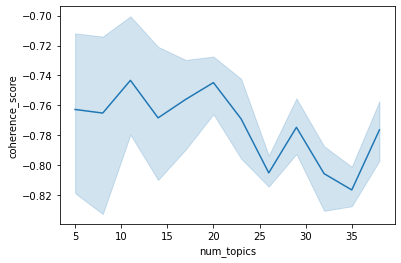

In [61]:
import seaborn as sns

ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

# Sources

### *References*
* [Andrew Ng et al paper on LDA](https://ai.stanford.edu/~ang/papers/jair03-lda.pdf)
* On [Coherence](https://pdfs.semanticscholar.org/1521/8d9c029cbb903ae7c729b2c644c24994c201.pdf)

### *Resources*

* [Gensim](https://radimrehurek.com/gensim/): Python package for topic modeling, nlp, word vectorization, and few other things. Well maintained and well documented.
* [Topic Modeling with Gensim](http://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#11createthedictionaryandcorpusneededfortopicmodeling): A kind of cookbook for LDA with gensim. Excellent overview, but the you need to be aware of missing import statements and assumed prior knowledge.
* [Chinese Restuarant Process](https://en.wikipedia.org/wiki/Chinese_restaurant_process): That really obscure stats thing I mentioned... 
* [PyLDAvis](https://github.com/bmabey/pyLDAvis): Library for visualizing the topic model and performing some exploratory work. Works well. Has a direct parrell implementation in R as well. 
* [Rare Technologies](https://rare-technologies.com/): The people that made & maintain gensim and a few other libraries.
* [Jane Austen v. Charlotte Bronte](https://www.literaryladiesguide.com/literary-musings/jane-austen-charlotte-bronte-different-alike/)